<a href="https://colab.research.google.com/github/fkonrad97/Network/blob/main/routingtable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import csv
import pandas as pd
import numpy as np
import networkx as nx
import random
import math
from scipy.stats import entropy
import matplotlib.pyplot as plt
import statistics

# I/O

In [26]:
# Read positions of nodes (X,Y,Z)

def positionRead(name):
    positions = pd.read_csv(name + ".csv", header=None, sep=";")
    # Remove a plus sign from the end of the number
    positions[0][0] = positions[0][0][:-1]
    positions[0] = positions[0].astype(float)    # Convert data to numerical value
    return positions

In [27]:
# Read connection table between nodes

def connectionRead(name):
    connections = pd.read_csv(name + ".csv", header=None)
    return connections

In [28]:
# List of the positions of nodes
# positions = positionRead("Network/Brain_data/Brain1Positions")
positions = positionRead("/content/Brain1Positions")

# List of how nodes connected to each other
# connections = connectionRead("Network/Brain_data/Brain1Connections")
connections = connectionRead("/content/Brain1Connections")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Additional Methods

In [29]:
# Calculate distance between 2 points in Euclidean space
# Positions should be 3D (X,Y,Z)

def Euclidean_dist(p1, p2):
    point1 = np.array((positions[0][p1], positions[1][p1], positions[2][p1]))
    point2 = np.array((positions[0][p2], positions[1][p2], positions[2][p2]))
    return np.linalg.norm(point1 - point2)

In [30]:
def Euclidean_dist2D(p1, p2):
    point1 = np.array((p1[0], p1[1]))
    point2 = np.array((p2[0], p2[1]))
    return np.linalg.norm(point1 - point2)

In [31]:
def hyperbolicDist(coord1, coord2):
  x1 = coord1[0]
  y1 = coord1[1]
  x2 = coord2[0]
  y2 = coord2[1]

  return np.arccosh(np.cosh(y1)*np.cosh(x2-x1)*np.cosh(y2)-np.sinh(y1)*np.sinh(y2))

In [32]:
# Add a key-value pair to the existing dictionary

def add_element(dict, key, value):
    if key not in dict:
        dict[key] = []
    dict[key].append(value)

In [33]:
# Returns with a dictionary. Key is the number of the node and 
# the value is the distant between the current node(act) and its neighbour.
# The list is ascendant by the distance.

def get_dist(act, neighbours):
    dist = {}
    
    for i in neighbours:
        add_element(dist, i, Euclidean_dist(act, i))
    
    dist = sorted(dist.items(), key=lambda x: x[1])
    
    return dist

In [34]:
def chooseRandomShortest(paths):
  randomPaths = []

  for i in paths:
    randomPaths.append(random.choice(i))

  return randomPaths

In [35]:
def avgEntropy(graph, routingTables):
  sum = 0

  for i in range(len(graph.nodes)):
    routingTables[i].getNextHopsList()
    sum += entropy(routingTables[i].nextHops)
  
  return (sum / len(graph.nodes))

In [36]:
def readWeightedIn():
  greedyNeighbours = []
  for i in range(len(connections)):
    for j in range(len(connections)):
       if connections[i][j] == 1 and i < j:
          dist = Euclidean_dist(i,j)
          greedyNeighbours.append([i,j,dist])
  return greedyNeighbours

In [37]:
def readUnweightedIn():
  neighbours = []
  for i in range(len(connections)):
    for j in range(len(connections)):
      if connections[i][j] == 1 and i < j:
        neighbours.append([i, j])
  return neighbours

# Graph algorithms

In [38]:
def findPaths(src, graph):
  paths = []

  for j in range(len(graph.nodes)):
    if src!=j:
      path = [p for p in nx.all_shortest_paths(graph, source=src, target=j)]
      paths.append(path)
  
  return paths

In [39]:
def greedy(graph, src, dest):
  pathsGreedy = []
  pathsGreedy.append(src)
  ready = False
  act = src

  while ready==False:
    nbours = [n for n in graph.neighbors(act)]

    # Calculates the distances of the neighbour nodes from the end node
    dist = get_dist(dest, nbours)

    # if the 'dest' is connected with 'act'
    if dest in nbours:
      pathsGreedy.append(dest)
      return pathsGreedy

    # if 'act' has no neighbours 
    elif len(nbours) == 0:
      return "No neighbours"

    # if 'act' has just 1 neighbour
    elif len(nbours) == 1:
      act = nbours[0]
      pathsGreedy.append(act)

    elif len(nbours) > 1:
      not_found = False
      for i in dist:
        if i[0] not in pathsGreedy:
          act = i[0]
          pathsGreedy.append(act)
          not_found = True
          break
      # If there are no more choosable node on the list
      if not_found == False:
        act = dist[0][0]
        pathsGreedy.append(act)

# Network Generator

In [40]:
class Network:
    def __init__(self, inputRadius):
      self.inputRadius = inputRadius
      self.xCoordinate = []
      self.yCoordinate = []
      self.coordinates = []
      self.edges = []

    def add_edge(self, src, dest):
      edge = [src, dest]
      self.edges.append(edge)

    def growNetwork(self):
      for i in range(len(self.coordinates)):
        for j in range(len(self.coordinates)):
          if self.coordinates[i] != self.coordinates[j]:
            dist = hyperbolicDist(self.coordinates[i],self.coordinates[j])
            if dist < self.inputRadius:
              self.add_edge(i,j)

    def generatePoint(self):
      radius = self.inputRadius * math.sqrt(random.random())
      theta = 2 * math.pi * random.random()

      return radius * math.cos(theta), radius * math.sin(theta)

    def createNodes(self, n):
      self.xCoordinate, self.yCoordinate =  [], []
      for i in range(n):
          xc, yc = self.generatePoint()
          self.xCoordinate.append(xc)
          self.yCoordinate.append(yc)
      self.convertCoords(n)

    def convertCoords(self, n):
        for i in range(n):
           self.coordinates.append([self.xCoordinate[i], self.yCoordinate[i]])

    def plot(self):
        plt.figure(1)
        plt.plot(self.xCoordinate, self.yCoordinate,'b.')
        plt.grid('on')

        x_circle = [self.inputRadius*math.cos(i) for i in np.arange(0, math.pi*2, 0.01)]
        y_circle = [self.inputRadius*math.sin(i) for i in np.arange(0, math.pi*2, 0.01)]
        plt.plot(x_circle, y_circle, '-k')

# Classes

In [41]:
class Graph():
  def __init__(self,):
    self.G = nx.Graph()
    self.nodes = self.G.nodes

  def addWeightedEdges(self):
    neighborList = readWeightedIn()
    for i in neighborList:
      self.G.add_edge(i[0], i[1], weight=i[2])

  def addWeightedNetworkEdges(self, network):
    for i in network.edges:
      self.G.add_edge(i[0], i[1], weight=Euclidean_dist2D(network.coordinates[i[0]],network.coordinates[i[1]]))

  def addUnweightedEdges(self):
    neighborList = readUnweightedIn()
    for i in neighborList:
      self.G.add_edge(i[0],i[1])

In [42]:
class routingTable():

  def __init__(self, nodeID, graph):
    self.graph = graph.G
    self.nodeID = nodeID
    self.table = []
    self.nextHops = []

  def addtoTable(self, dest, nextHop):
    self.table.append([dest, nextHop])

  def findNextHop(self):
    paths = findPaths(self.nodeID, self.graph)
    paths = chooseRandomShortest(paths)
    for i in paths:
      self.addtoTable(i[-1], i[1])

  def findNextHopGreedy(self):
    paths = []
    for i in range(len(self.graph.nodes)):
      if self.nodeID!=i:
        paths.append(greedy(self.graph, self.nodeID, i))
    for i in paths:
      self.addtoTable(i[-1], i[1])

  def getNextHopsList(self):
    self.nextHops = []
    for i in self.table:
      self.nextHops.append(i[1])

# **GREEDY ALGORITHM**

In [43]:
Ggreedy = Graph()
Ggreedy.addWeightedEdges()

routingTablesGreedy = []

for i in Ggreedy.nodes:
  table = routingTable(i, Ggreedy)
  table.findNextHopGreedy()
  routingTablesGreedy.append(table)

In [44]:
entropyGreedyValue = avgEntropy(Ggreedy, routingTablesGreedy)
entropyGreedyValue

4.24936333658451

# **RANDOM UNWEIGHTED**

In [45]:
G = Graph()
G.addUnweightedEdges()

In [46]:
# Each nodes' routing table
routingTables = []

for j in range(10):
  routingtable = []
  for i in range(len(G.nodes)):
    table = routingTable(i,G)
    table.findNextHop()
    routingtable.append(table)
  routingTables.append(routingtable)

In [47]:
entropyList = []

for i in routingTables:
  entropyList.append(avgEntropy(G, i))

In [48]:
entropyList

[4.246082065185657,
 4.245827763828484,
 4.247612167534285,
 4.248365206684406,
 4.249571228835414,
 4.244239889935784,
 4.245189581893648,
 4.246747894279199,
 4.247646345815786,
 4.245918459095263]

In [49]:
statistics.mean(entropyList)

4.2467200603087925

# **KRIUKOV GRÁFGENERÁLÁS**

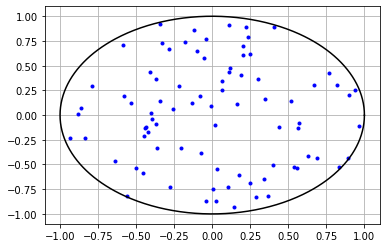

In [50]:
# Generate network

network = Network(1)
network.createNodes(83)
network.growNetwork()
network.plot()

In [52]:
GKriukov = Graph()
GKriukov.addWeightedNetworkEdges(network)

### **Random Kriukov**

In [53]:
# Each nodes' routing table
routingTablesKriukov = []

for j in range(10):
  routingtable = []
  for i in range(len(GKriukov.nodes)):
    table = routingTable(i,GKriukov)
    table.findNextHop()
    routingtable.append(table)
  routingTablesKriukov.append(routingtable)

In [54]:
entropyListKriukov = []

for i in routingTablesKriukov:
  entropyListKriukov.append(avgEntropy(GKriukov, i))

In [55]:
entropyListKriukov

[4.196811021807664,
 4.192654860149303,
 4.196751414528082,
 4.195427982501107,
 4.1975344463329956,
 4.198182333312832,
 4.193772462368822,
 4.196337622203716,
 4.197173250391043,
 4.196805457510107]

##Greedy Kriukov

In [56]:
routingTablesGreedyKriukov = []

for i in GKriukov.nodes:
  table = routingTable(i, GKriukov)
  table.findNextHopGreedy()
  routingTablesGreedyKriukov.append(table)

In [57]:
entropyGreedyKriukovValue = avgEntropy(GKriukov, routingTablesGreedyKriukov)
entropyGreedyKriukovValue

4.209163464450574